# Deliverable 2 - Grupo 01 - DEX04
## Importe das bibliotecas e criação do DataFrame.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
# Carregando .csv para o DataFrame
dataset = pd.read_csv('/content/drive/MyDrive/Walmart.csv')

# Convertendo os dados de data de String para DateTime
dataset.Date = pd.to_datetime(dataset.Date)

# Criando uma coluna com o número da semana para potencial consulta de 
# resultados
dataset['Week_Number'] = dataset.Date.dt.isocalendar().week


### Sobre os dados
Este é o conjunto de dados de 05-02-2010 até 01-11-2012 do WalmartStoresales. 
Neste aqrquivo você encontrará as seguintes variáveis:

**Store** - the store number

**Date** - the week of sales

**Weekly_Sales** - sales for the given store

**Holiday_Flag** - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week

**Temperature** - Temperature on the day of sale

**Fuel_Price** - Cost of fuel in the region

**CPI** – Prevailing consumer price index

**Unemployment** - Prevailing unemployment rate

**Holiday Events**\
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## Questionamento:
**Com base nos dados fornecidos, em qual loja deve-se investir?**

Iniciando os Estudos:

In [ ]:
# Criando listas com strings das datas de feriado para comparação futura
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'] 
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
labourday_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']

#Nas datas do Superbowl, as lojas não funcionam!!!!!
superbowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']


In [ ]:
#Criando funções de utilidades.
# Criando uma função para filtrar os dataframes por lista de datas de feriados
def df_datefilter(dataframe, date_list):
  return dataframe[dataframe.Date.isin(date_list)]

# Criando uma função para pegar as semanas das datas.
def week_getter(datelist):
  weeks = set()
  for date in datelist:
    if date[5] == '0':
      yr = int(date[:4])
      mth = int(date[6:7])
      day = int(date[8:10])
      weeks.add(dt.date(yr, mth, day).isocalendar()[1])
    else:
      yr = int(date[:4])
      mth = int(date[5:7])
      day = int(date[8:10])
      weeks.add(dt.date(yr, mth, day).isocalendar()[1])
  return weeks

# Função para filtrar o dataframe por lista com números de semanas dos feriados
def df_weekfilter(dataframe, weeklist):
  return dataframe[dataframe.Week_Number.isin(weeklist)]

#Função para calcular o limite dos outliers:
def inner_fences(dataframe, variable):
  q1 = dataframe[str(variable)].quantile(0.25)
  q3 = dataframe[str(variable)].quantile(0.75)
  iqr = (q3 - q1) * 1.5
  return (( q1 - iqr ), ( q3 + iqr ))
 



In [ ]:
#Checando se as variáveis têm valores nulos
variaveis = list(dataset.columns)
v_nulo = list()
for variavel in variaveis:
  if dataset[variavel].hasnans:
    v_nulo.append(variavel)
print(v_nulo) #sem valores nulos


[]


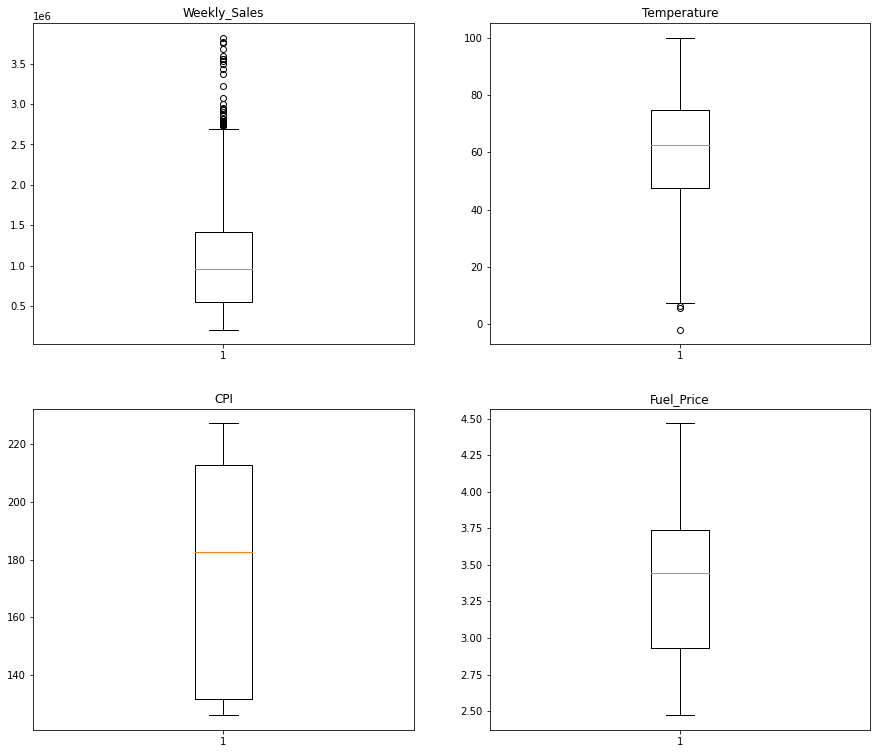

In [ ]:
# Visualizando presença de outliers em variáveis quantitativas.

fig, ax = plt.subplots(2,2, figsize=(15,13))

ax[0,0].boxplot(dataset.Weekly_Sales)
ax[0,0].set_title(dataset['Weekly_Sales'].name)

ax[0,1].boxplot(dataset.Temperature)
ax[0,1].set_title(dataset['Temperature'].name)

ax[1,0].boxplot(dataset.CPI)
ax[1,0].set_title(dataset['CPI'].name)

ax[1,1].boxplot(dataset.Fuel_Price)
ax[1,1].set_title(dataset['Fuel_Price'].name)
plt.show()

#outliers detectados no Weekly_Sales (esperado) e na Temperatura.


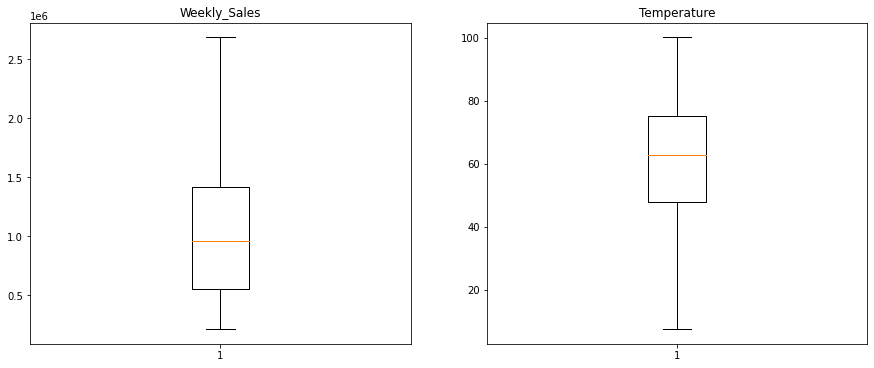

In [ ]:
#Removendo Outliers de temperatura e vendas semanais
ds_no_out = dataset.loc[(dataset['Weekly_Sales'] < inner_fences(dataset,
'Weekly_Sales')[1])].loc[(dataset['Temperature'] > inner_fences(dataset,
'Temperature')[0])]

fig, ax = plt.subplots(2,2, figsize=(15,13))

ax[0,0].boxplot(ds_no_out.Weekly_Sales)
ax[0,0].set_title(ds_no_out['Weekly_Sales'].name)

ax[0,1].boxplot(ds_no_out.Temperature)
ax[0,1].set_title(ds_no_out['Temperature'].name)

ax[1,0].set_visible(False)
ax[1,1].set_visible(False)

plt.show()

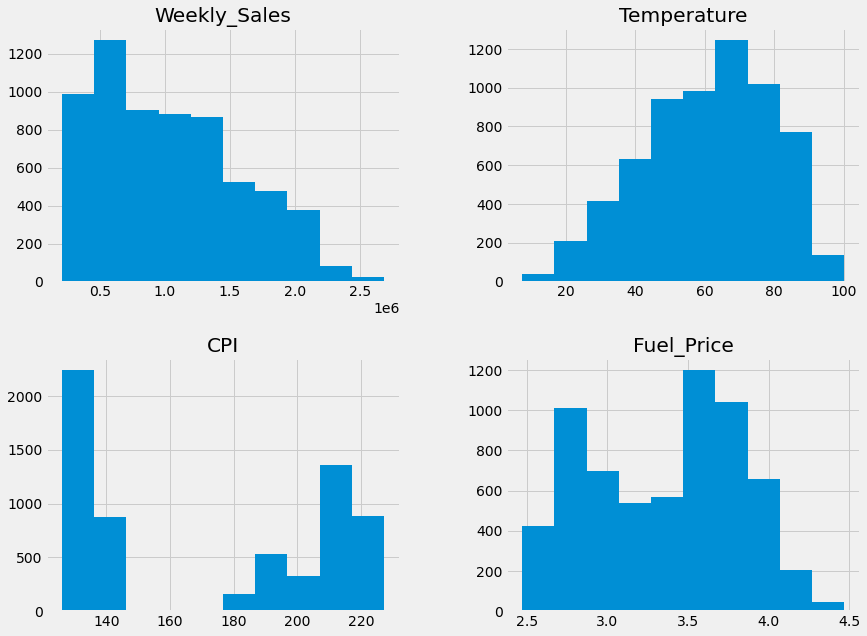

In [55]:
#Visualizando variáveis quantitativas.
plt.style.use('fivethirtyeight')
ds_no_out.hist(column=['Weekly_Sales', 'Temperature', 'CPI', 'Fuel_Price'],
figsize=(13,10))
plt.show()

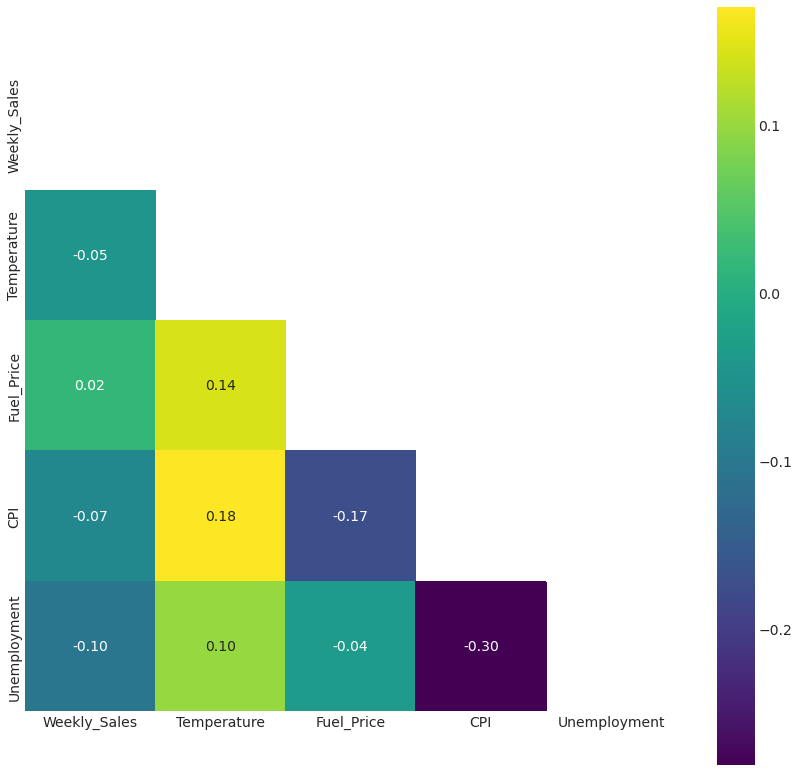

In [64]:
#checagem da matriz de correlação.

ds_hmap = ds_no_out.drop(labels=['Store', 'Date', 'Holiday_Flag', 'Week_Number']
                         , axis=1)

mask = np.zeros_like(ds_hmap.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(13,13))
    ax = sns.heatmap(ds_hmap.corr(),mask=mask, square=True, annot=True,
                     fmt='.2f', cmap='viridis', robust=True)
plt.show()
#Correlação muito fraca das variáveis quantitativas.

In [ ]:
# Filtrando o dataset por vendas nos feriados de natal (Usando dataset sem Outliers)
ds_christmas = df_weekfilter(ds_no_out, week_getter(christmas_dates))
ds_thanksgiving = df_weekfilter(ds_no_out, week_getter(thanksgiving_dates))
ds_labourday = df_weekfilter(ds_no_out, week_getter(labourday_dates))
ds_superbowl = df_weekfilter(ds_no_out, week_getter(superbowl_dates)) 
#ds_christmas.groupby('Store').sum().sort_values('Weekly_Sales', ascending=False)